In [92]:
import pandas as pd
import numpy as np
import os
from utils_dist_corr import *
from scipy.stats import spearmanr
import pingouin as pg 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path_script = '/Users/alouette/Documents/Perceptual_Space_ALS/Python/'
path_pca = '/Users/alouette/Documents/Perceptual_Space_ALS/df_pca/'

### Compute physical space + get data from encoding (pos, box, stim)

In [ ]:
pca_name = path_data+'evals_su={}_stim=ALL_ALL_PCA.csv'
stims = ['music','odor','face']

#get encoding config by subj + box coordinates
df_enc = pd.read_csv(path_script+'all_encodage.csv')
df_xy = pd.read_csv(path_script+'df_boxes.csv',index_col=0)
pairs = define_pairs(df_xy['box'])
dist = compute_all_dist(df_xy, pairs, name_col='box',
                           x_col='x', y_col='y')
phys_ = np.concatenate((np.array(pairs,dtype=str),dist[:,np.newaxis]),axis=1)
df_phys = pd.DataFrame(data=phys_, columns=['box1','box2','dist_phys'])
df_phys.to_csv(path_script+'df_phys_space_boxes.csv',index=False)
df_phys[['box1','box2']] = df_phys[['box1','box2']].astype(int)

#select only non-outliers subjects
subjs_sel = pd.read_csv(path_script+'all_evals_clean_n=48.csv')['subject']
subjects = np.unique(subjs_sel)

#create a df with physical and perceptual distances
for su in subjects:
    df_su = df_phys
    for stim in stims:
        #get the correspondance stim > box 
        conf_su = df_enc[df_enc['subject']==su][['box_num',stim]]
        conf_su = conf_su.drop_duplicates()
        dict_box = conf_su.set_index('box_num').T.to_dict('list')
        
        #relabel physical df with corresponding stimuli
        df_su[stim+'1'] = [x[0] for x in df_phys['box1'].map(dict_box)]
        df_su[stim+'2'] = [x[0] for x in df_phys['box2'].map(dict_box)]
    df_su.to_csv(path_pca+'{}_df_pos_box_stim.csv'.format(su), index=False)

### Associate physical and perceptual space by subject
For each sensory modality - compute the relationship btw physical and perceptual spaces

In [ ]:
def create_col_pairs_2sides(df, colA, colB):
    "combine info in colA and colB in 2 possible order"
    df['pairs1'] = [c1+c2 for c1, c2 in zip(df[colA],df[colB])]
    df['pairs2'] = [c2+c1 for c1, c2 in zip(df[colA],df[colB])]   
    return df

In [ ]:
stims = ['music','face','odor']

R_all = np.zeros((len(subjects),3)) 
for i,stim in enumerate(stims):
    #get all perceptual distance for a sensory modality
    df_perc = pd.read_csv(path_script+'all_dist_stim='+stim+'.csv',index_col=0)
    subjects = [c for c in df_perc.columns if c not in ('p0','p1')]
    
    for j,su in enumerate(subjects):
        #get encoding stimuli and their physical distance
        df_phys = pd.read_csv(path_pca+'{}_df_pos_box_stim.csv'.format(su))
        cols_sel = [stim+'1',stim+'2','dist_phys']
        df_phys = df_phys[cols_sel]
        enc_stim = np.unique(df_phys[[stim+'1',stim+'2']].values)
        
        #get perceptual distance for encoding stimuli only
        df_p_su = df_perc[['p0','p1',su]]
        df_p_su = df_p_su.loc[df_p_su['p0'].isin(enc_stim) & df_p_su['p1'].isin(enc_stim)]

        #combine infos (whatever the order of the 2 stimuli in each pair) > tricky
        df_p_su = create_col_pairs_2sides(df_p_su, colA='p0', colB='p1')
        df_phys = create_col_pairs_2sides(df_phys, colA=stim+'1', colB=stim+'2')
        
        phys_dist = []
        for c in df_p_su['pairs1']:
            d = df_phys.loc[(df_phys['pairs1']==c) | (df_phys['pairs2']==c)][['dist_phys']]
            phys_dist.append(d.values[0][0])
        df_p_su['dist_phys'] = phys_dist
        
        #compute Spearman correlation between 2 spaces
        R = spearmanr(df_p_su['dist_phys'],df_p_su[su])[0] #col named by su == perceptual space
        R_all[j,i] += R

data_all = np.concatenate((np.array(subjects)[:,np.newaxis], R_all),axis=1)
df_phys_perc = pd.DataFrame(data=data_all, columns=['subjects']+stims)
df_phys_perc[stims].astype(float)
df_phys_perc.to_csv(path_script+'df_phys_perc_space_allstims_v=allmod.csv', index=False)

### Compare physical - perceptual link across modalities

In [ ]:
#load all data (R spearman for all modalitites and subjects)
df_R = pd.read_csv(path_script+'df_phys_perc_space_allstims_v=allmod.csv')
#print(df_R.describe())

# Plot results 
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
df_R.boxplot(column=stims, ax=axes)

# Compute 1-way repeated measures ANOVA
df_piv = df_R[stims].melt()
df_piv.columns = ['stims','phys_perc_R']
df_piv['subjects'] = np.concatenate([df_R['subjects']]*3)
anova = pg.rm_anova(data=df_piv, dv='phys_perc_R', within='stims',
                    subject='subjects')
pg.print_table(anova, floatfmt='.3f')

# Bonf-corrected post hocs with Hedges'g effect size
posthoc = pg.pairwise_tests(data=df_piv, dv='phys_perc_R', within='stims',
                            subject='subjects', padjust='bonf')
pg.print_table(posthoc, floatfmt='.3f')

# Pairwise correlations between sensory modality
pair_r = pg.pairwise_corr(df_R, method='pearson')
print(pair_r)

### Correlate Phys-Perc link with behav perf 
Navigation parameters by participant and memory performance

#### ENCODING DATA

In [40]:
path_mem = '/Users/alouette/Documents/Perceptual_Space_ALS/old/'
stims = ['odor','music','face']

#load df with R Phys-Perc links by participant
df_R = pd.read_csv(path_script+'df_phys_perc_space_allstims_v=allmod.csv')
df_R = df_R.sort_values(['subjects'])
print(df_R.dtypes)
df_R['allmod'] = df_R[stims].mean(axis=1)
df_enc = pd.read_csv(path_mem+'all_encodage.csv')

#avg nb of clicks by box at encoding
df_enc = df_enc.loc[df_enc['subject'].isin(subjects_no_out)]
df_gr = df_enc.groupby(['subject']).count().iloc[:,0]

#check if 2 df are in the same order and add encoding data
print('2 df in the same order => ', any(df_R.subjects == df_gr.index))
df_R['nb_clicks'] = df_gr.values

df_gr2 = df_enc.groupby(['subject','box_num']).count().iloc[:,0].groupby(['subject']).mean()
print('2 df in the same order => ', any(df_R.subjects == df_gr2.index))
df_R['avg_clicks'] = df_gr2.values

# Pairwise correlations between sensory modality
pair_r = pg.pairwise_corr(df_R, method='pearson')
print(pair_r)

subjects     object
music       float64
face        float64
odor        float64
dtype: object
2 df in the same order =>  True
2 df in the same order =>  True
            X           Y   method alternative   n         r          CI95%  \
0       music        face  pearson   two-sided  48  0.096243  [-0.19, 0.37]   
1       music        odor  pearson   two-sided  48  0.115582  [-0.17, 0.39]   
2       music      allmod  pearson   two-sided  48  0.658996   [0.46, 0.79]   
3       music   nb_clicks  pearson   two-sided  48  0.045236  [-0.24, 0.33]   
4       music  avg_clicks  pearson   two-sided  48  0.045236  [-0.24, 0.33]   
5        face        odor  pearson   two-sided  48 -0.082238  [-0.36, 0.21]   
6        face      allmod  pearson   two-sided  48  0.598254   [0.38, 0.75]   
7        face   nb_clicks  pearson   two-sided  48 -0.035378  [-0.32, 0.25]   
8        face  avg_clicks  pearson   two-sided  48 -0.035378  [-0.32, 0.25]   
9        odor      allmod  pearson   two-sided  48  

#### RETRIEVAL DATA
All modalities at the same time (R global avec perf globales)

In [74]:
path_mem = '/Users/alouette/Documents/Perceptual_Space_ALS/old/'
stims = ['odor','music','face']

#load df with R Phys-Perc links by participant
df_R = pd.read_csv(path_script+'df_phys_perc_space_allstims_v=allmod.csv')
df_R = df_R.sort_values(['subjects'])
df_R['allmod'] = df_R[stims].mean(axis=1)
df_ret = pd.read_excel(path_mem+'all_rappel_score.xls')
#print(df_ret.head(10))

#global recognition performance
df_ret = df_ret.loc[df_ret['subject'].isin(subjects_no_out)]
df_gr = df_ret.groupby(['subject','score_recognition']).count()['trial_num']
df_gr = df_gr.unstack().fillna(0) #replace NaN values by 0
df_gr['HR'] = (df_gr['hit'] + 0.5) / (27 + 1)
df_gr['FR'] = (df_gr['fa'] + 0.5) / (27 + 1)
df_gr['d_prime'] = np.log((df_gr['HR'] * (1 - df_gr['FR']))/(df_gr['FR'] * (1 - df_gr['HR'])))

print('2 df in the same order => ', any(df_R.subjects == df_gr.index))
df_tot = df_R.merge(df_gr, left_on='subjects', right_on='subject')
pair_allmod = pg.pairwise_corr(df_tot[['d_prime','hit','fa','allmod']],
                              method='pearson')
#print(pair_allmod.loc[pair_allmod['p-unc']<0.05])

#global episodic performance
df_gr2 = df_ret.groupby(['subject','episodic_score']).count()['trial_num']
df_gr2 = df_gr2.unstack().fillna(0) #replace NaN values by 0
df_gr2['WWW-R'] = (df_gr2['www'] + 0.5) / (27 + 1)
df_gr2['W-R'] = (df_gr2['w'] + 0.5) / (27 + 1)
print('2 df in the same order => ', any(df_R.subjects == df_gr2.index))
df_tot2 = df_R.merge(df_gr2, left_on='subjects', right_on='subject')
pair_allmod2 = pg.pairwise_corr(df_tot2[['WWW-R','W-R','allmod']],
                              method='pearson')
print(pair_allmod2.loc[pair_allmod2['p-unc']<0.05])


2 df in the same order =>  True
2 df in the same order =>  True
       X    Y   method alternative   n         r          CI95%         p-unc  \
0  WWW-R  W-R  pearson   two-sided  48 -0.660308  [-0.8, -0.46]  3.286469e-07   

        BF10     power  
0  5.556e+04  0.999671  


#### RETRIEVAL DATA
BY modality (Link R specific and perf specific)

(2583, 46)

 >>> Exploring link R and memory perf for  odor
2 df in the same order =>  True

          X     Y   method alternative   n         r           CI95%  \
1  d_prime    FR  pearson   two-sided  47 -0.847617  [-0.91, -0.74]   
2  d_prime  odor  pearson   two-sided  47  0.301888    [0.02, 0.54]   

          p-unc       BF10     power  
1  5.701842e-14  1.333e+11  1.000000  
2  3.917902e-02      1.431  0.550093  

 >>> Exploring link R and memory perf for  music
2 df in the same order =>  True

 >>> Exploring link R and memory perf for  face
2 df in the same order =>  True


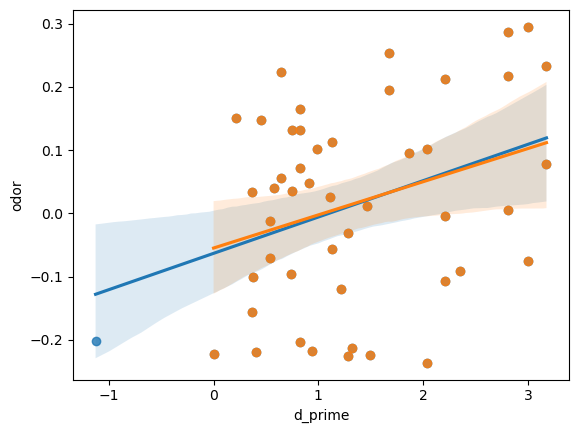

In [118]:
path_mem = '/Users/alouette/Documents/Perceptual_Space_ALS/old/'
stims = ['odor','music','face']

#load df with R Phys-Perc links by participant
df_R = pd.read_csv(path_script+'df_phys_perc_space_allstims_v=allmod.csv')
df_R = df_R.sort_values(['subjects'])
df_R['allmod'] = df_R[stims].mean(axis=1)
df_ret = pd.read_excel(path_mem+'all_rappel_score.xls',index_col=0)
df_ret = df_ret.loc[df_ret['subject'].isin(subjects_no_out)]
print(df_ret.shape)

for stim in stims:
    print("\n >>> Exploring link R and memory perf for ", stim)
    
    #filter data by sensory modality
    df_stim = df_ret[~df_ret[stim].isna()]
    
    #global recognition performance
    df_gr = df_stim.groupby(['subject','score_recognition']).count()['trial_num']
    df_gr = df_gr.unstack().fillna(0) #replace NaN values by 0
    df_gr['HR'] = (df_gr['hit'] + 0.5) / (27 + 1)
    df_gr['FR'] = (df_gr['fa'] + 0.5) / (27 + 1)
    df_gr['d_prime'] = np.log((df_gr['HR'] * (1 - df_gr['FR']))/(df_gr['FR'] * (1 - df_gr['HR'])))

    #print('2 df in the same order => ', any(df_R.subjects == df_gr.index))
    df_tot = df_R.merge(df_gr, left_on='subjects', right_on='subject')
    pair_allmod = pg.pairwise_corr(df_tot[['d_prime','HR','FR',stim]],
                                  method='pearson')
    #print('\n', pair_allmod.loc[pair_allmod['p-unc']<0.05])
    
    #global episodic performance
    df_gr2 = df_stim.groupby(['subject','episodic_score']).count()['trial_num']
    df_gr2 = df_gr2.unstack().fillna(0) #replace NaN values by 0
    df_gr2['WWW-R'] = (df_gr2['www'] + 0.5) / (27 + 1)
    df_gr2['W-R'] = (df_gr2['w'] + 0.5) / (27 + 1)
    print('2 df in the same order => ', any(df_R.subjects == df_gr2.index))
    df_tot2 = df_R.merge(df_gr2, left_on='subjects', right_on='subject')
    pair_allmod2 = pg.pairwise_corr(df_tot2[['WWW-R','W-R','allmod']],
                                  method='pearson')
    #print(pair_allmod2.loc[pair_allmod2['p-unc']<0.05])
    
    if stim == 'odor':
        df2_z = abs(stats.zscore(df_tot.iloc[:,1:],axis=0))
        max_dev = 2
        df2_clean = df_tot[(df2_z[['d_prime']] < max_dev).all(axis=1)]
        pair_allmod = pg.pairwise_corr(df2_clean[['d_prime','HR','FR',stim]],
                                  method='pearson')
        print('\n', pair_allmod.loc[pair_allmod['p-unc']<0.05])
        sns.regplot(x="d_prime", y=stim, data=df_tot);
        sns.regplot(x="d_prime", y=stim, data=df2_clean);
